In [17]:
import pandas as pd
import numpy as np
import logging
import gc
import sys

import seaborn as sns
import matplotlib.pyplot as plt

sys.path.append("../")

import src.features.outlier_correction as oc
from src.features import build_features
from src.models import feed_forward
from src.models import metric_calculation

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Training Data

In [3]:
feats = pd.read_csv("../data/processed/train_features.csv")
target = pd.read_csv("../data/processed/train_target.csv")

feats.set_index('card_id', inplace=True)
target.set_index('card_id', inplace=True)

In [6]:
outliers = oc.flag_normal_outliers(target, 4)
outliers = outliers.values.reshape(-1)
feats = feats[~outliers]
target = target[~outliers]

In [9]:
X = feats.values
y = target.values.reshape(-1)

# Validation Data

In [7]:
val_feats = pd.read_csv("../data/processed/validation_features.csv")
val_target = pd.read_csv("../data/processed/validation_target.csv")

val_feats.set_index("card_id", inplace=True)
val_target.set_index("card_id", inplace=True)

outliers = oc.flag_normal_outliers(val_target, 4)

outliers = outliers.values.reshape(-1)
val_feats = val_feats[~outliers]
val_target = val_target[~outliers]

X_val = val_feats.values
y_val = val_target.values.reshape(-1)

# Linear Regression (sklearn)

In [10]:
regr = LinearRegression()
regr.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

# Keras Perceptron

In [12]:
optim_type = 'adam'
loss_type = 'mse'
layers = [(64, 'normal', 'relu')]
perceptron = feed_forward.FeedForward("Perceptron", layers, X.shape[1], optim_type, loss_type)

2019-05-03 08:48:45,716 - tensorflow - WARNING - From /Users/kennedymurphy/elo/lib/python3.7/site-packages/tensorflow/python/framework/op_def_library.py:263: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


In [14]:
perceptron.model.fit(X, y, epochs=100, batch_size=64)

2019-05-03 08:49:18,691 - tensorflow - WARNING - From /Users/kennedymurphy/elo/lib/python3.7/site-packages/tensorflow/python/ops/math_ops.py:3066: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.


Epoch 1/100
163526/163526 [==============================] - 3s 18us/step - loss: 7.1257
Epoch 2/100
163526/163526 [==============================] - 3s 17us/step - loss: 2.8891
Epoch 3/100
163526/163526 [==============================] - 3s 17us/step - loss: 2.6649
Epoch 4/100
163526/163526 [==============================] - 3s 17us/step - loss: 2.6057
Epoch 5/100
163526/163526 [==============================] - 3s 17us/step - loss: 2.6743
Epoch 6/100
163526/163526 [==============================] - 3s 17us/step - loss: 2.5773
Epoch 7/100
163526/163526 [==============================] - 3s 17us/step - loss: 2.5880
Epoch 8/100
163526/163526 [==============================] - 3s 17us/step - loss: 2.5860
Epoch 9/100
163526/163526 [==============================] - 3s 18us/step - loss: 2.5952
Epoch 10/100
163526/163526 [==============================] - 3s 17us/step - loss: 2.6057
Epoch 11/100
163526/163526 [==============================] - 3s 17us/step - loss: 2.5510
Epoch 12/100
163526

# Model Validation Comparison

In [15]:
regr_pred = regr.predict(X)

In [16]:
perceptron_pred = perceptron.model.predict(X)

In [23]:
pred = pd.DataFrame({'target': y, "regression": regr_pred, "perceptron": perceptron_pred.reshape(-1)})

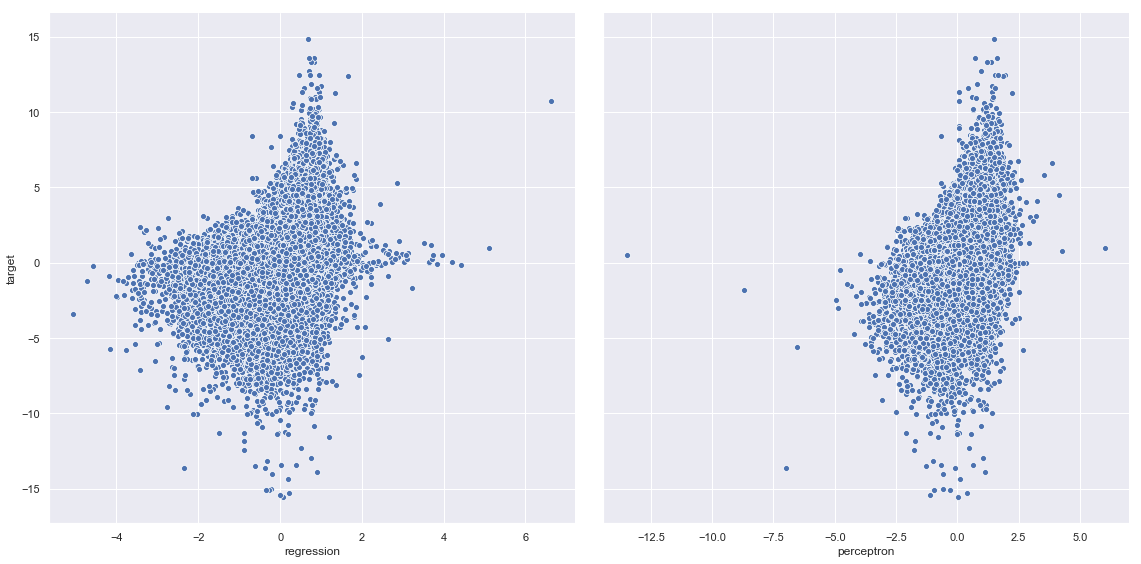

In [34]:
sns.set()
grid = sns.pairplot(
        pred,
        y_vars=['target'],
        x_vars=['regression', 'perceptron'],
        height=8)

plt.show()

In [35]:
pred['regression_residuals'] = pred['target'] - pred['regression']
pred['perceptron_residuals'] = pred['target'] - pred['perceptron']

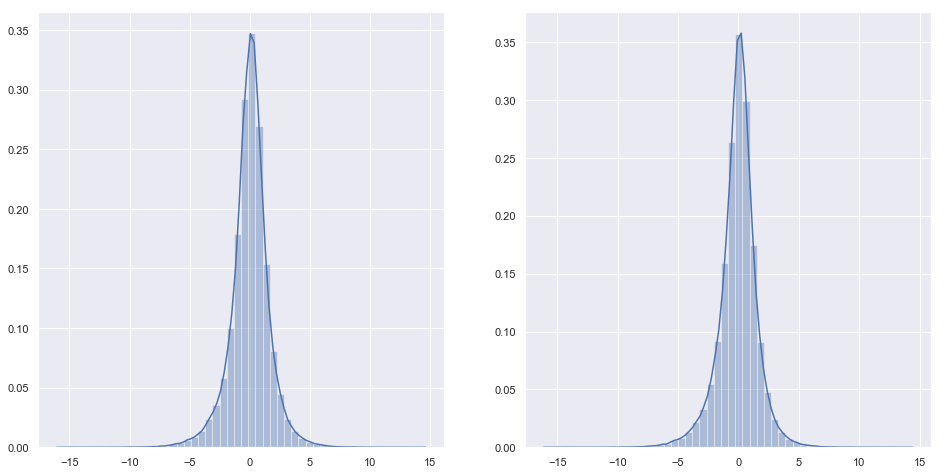

In [39]:
sns.set()

fig, ax = plt.subplots(1, 2, figsize=(16, 8))

sns.distplot(pred.regression_residuals.values, ax=ax[0])
sns.distplot(pred.perceptron_residuals.values, ax=ax[1])

plt.show()

In [40]:
pred.describe()

,target,regression,perceptron,regression_residuals,perceptron_residuals
count,163526.000000,163526.000000,163526.000000,163526.000000,163526.000000
mean,-0.030492,-0.030518,0.014050,0.000026,-0.044542
std,1.709588,0.571096,0.668648,1.611347,1.578269
min,-15.553269,-5.055407,-13.471536,-15.617985,-15.696773
25%,-0.841298,-0.340863,-0.372660,-0.761603,-0.785562
50%,-0.007763,-0.036976,-0.072054,0.064634,0.044284
75%,0.772901,0.343468,0.424124,0.842406,0.795774
max,14.855160,6.623065,6.019826,14.164356,13.982246
